У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
df = pd.read_csv('train_store.csv',sep=';')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)

In [4]:
display(df.head(10))
df.info()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



<Axes: xlabel='date', ylabel='sales'>

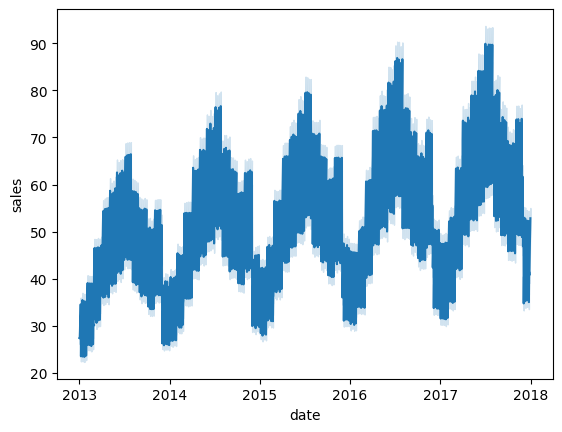

In [36]:
sns.lineplot(x=df.index, y=df['sales'])

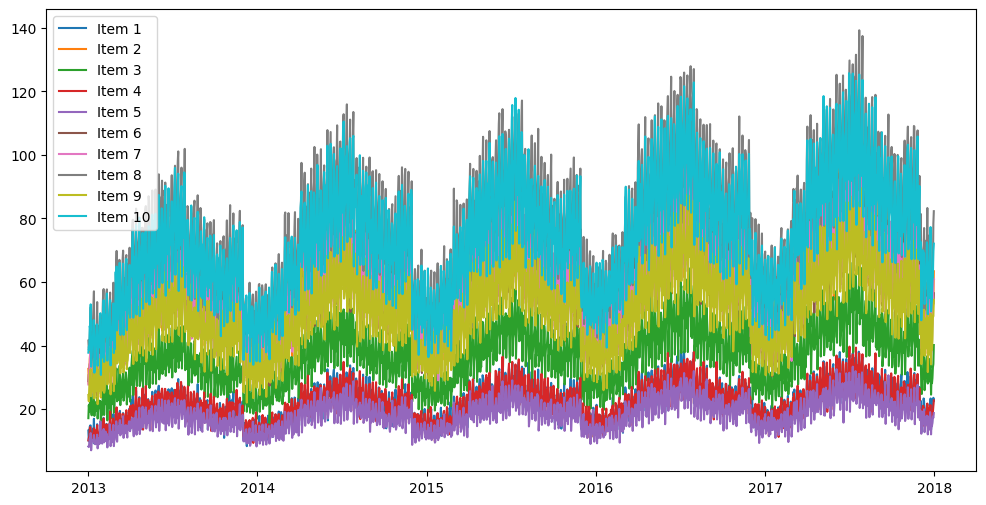

In [63]:
plt.figure(figsize=(12, 6))

for item_id in range(1,11):
    df_item = df[df["item"] == item_id]
    stats = df_item.groupby("date")["sales"].agg(["mean", "min", "max"]).reset_index()
    plt.plot(stats["date"], stats["mean"], label=f"Item {item_id}")
plt.legend()
plt.show()

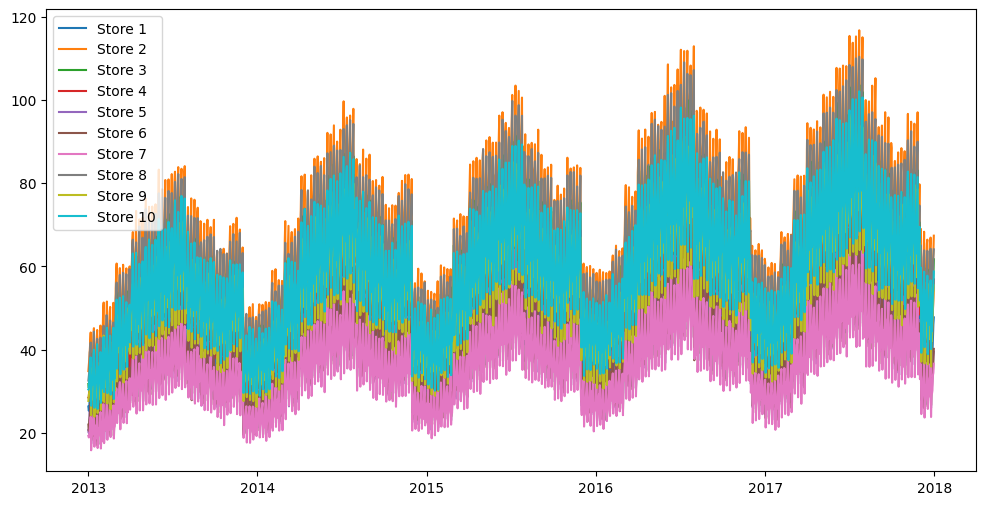

In [67]:
plt.figure(figsize=(12, 6))

for item_id in range(1,11):
    df_item = df[df["store"] == item_id]
    stats = df_item.groupby("date")["sales"].agg(["mean", "min", "max"]).reset_index()
    plt.plot(stats["date"], stats["mean"], label=f"Store {item_id}")
plt.legend()
plt.show()

- чітка сезонність: і для айтемів, і для магазинів мають схожі хвилі
- айтеми — є “топові” товари, які продаються краще
- магазини — теж є магазини які проадують більше, і менше, але всі за однаковою структорою

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [5]:
df_it1_st1 = df[(df['item']==1)&(df['store']==1)]

In [70]:
df_it1_st1

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,1,1,14
2017-12-28,1,1,19
2017-12-29,1,1,15


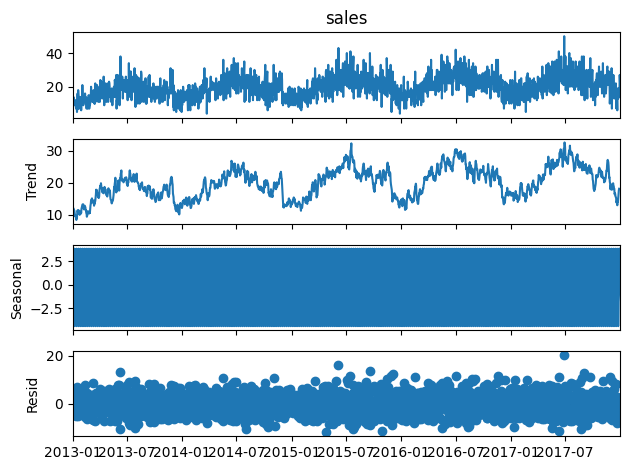

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_plot = seasonal_decompose(df_it1_st1.sales,model='additive')
decomposition_plot.plot()
plt.show()

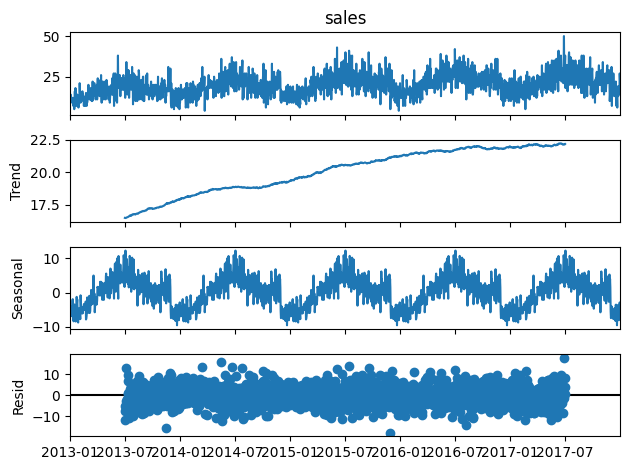

In [72]:
decomposition_plot365 = seasonal_decompose(df_it1_st1.sales,model='additive',period=365)
decomposition_plot365.plot()
plt.show()

- вивела другий графік, з періодом 365 днів, бо так сезоність дуже сплющена
- з сезонності видно залежність, є місяці з підйом, є з спадом
- багато резіделів, значить є багато випадків продажів які випадають з загальної картинки - акції, розпродажі або помилки
- також чітко видн лінію тренду, яка поступо піднімається

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [7]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
from darts import TimeSeries

In [9]:
series = TimeSeries.from_dataframe(df_it1_st1, value_cols='sales')

In [10]:
series

<TimeSeries (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='date'>

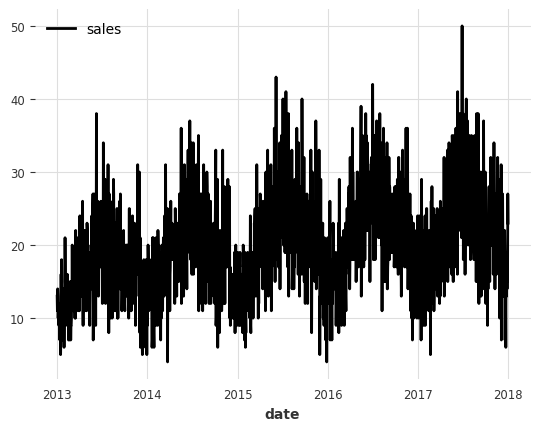

In [11]:
series.plot()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

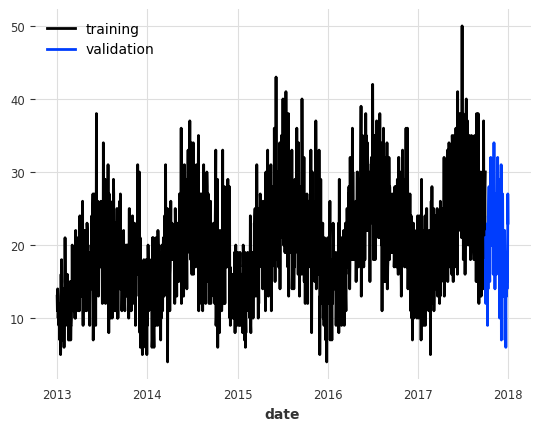

In [12]:
train, val = series.split_before(pd.Timestamp("2017-10-01"))
train.plot(label="training")
val.plot(label="validation")

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1000x600 with 0 Axes>

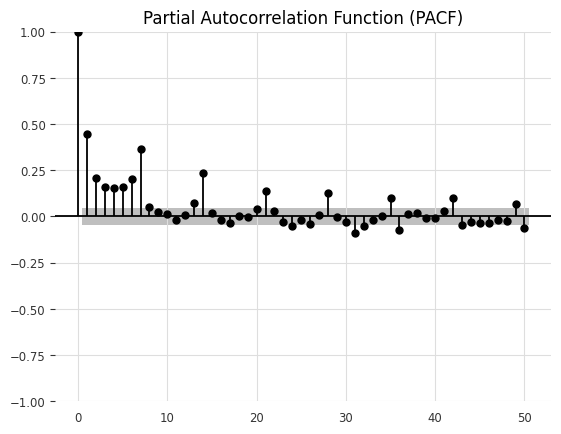

In [14]:
plt.figure(figsize=(10, 6))
plot_pacf(df_it1_st1.sales, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

- 1,7,14 - мають найбільшу кореляціюб і виходять за межі довірчого інтервалу

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [15]:
from darts.utils.statistics import check_seasonality

In [16]:
for m in range(2,25):
  is_seasonal, period = check_seasonality(train,m=m, alpha=0.05)
  if is_seasonal:
    print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [17]:
from darts.models import NaiveSeasonal

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x78de3c69a2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


In [19]:
n = len(val)

<Axes: xlabel='date'>

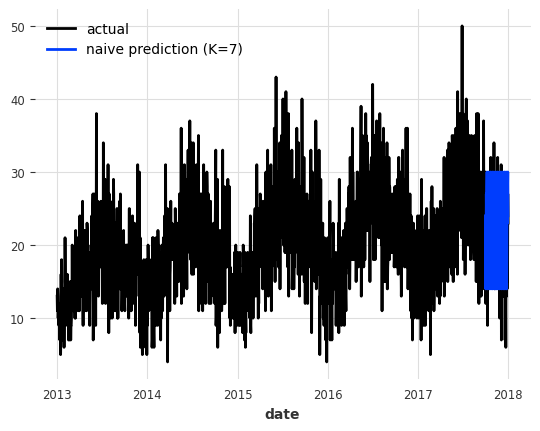

In [20]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(n)

series.plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=7)")

In [21]:
from darts.models import NaiveDrift

<Axes: xlabel='date'>

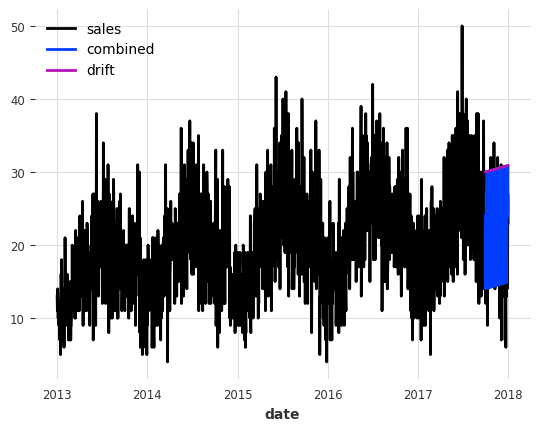

In [22]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(n)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [25]:
from darts.metrics import mape

In [26]:
print("Naive Seasonal MAPE:", mape(val, seasonal_forecast))
print("Naive Drift MAPE:", mape(val, drift_forecast))
print("Combined MAPE:", mape(val, combined_forecast))

Naive Seasonal MAPE: 38.174845664426456
Naive Drift MAPE: 68.74405050496789
Combined MAPE: 39.90628951234137


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [27]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

In [31]:
train.to_dataframe()

,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2017-09-26,18.0
2017-09-27,27.0
2017-09-28,23.0


In [33]:
def enrich_with_date_features(df):
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  return df

In [34]:
train_transformed = enrich_with_date_features(train.to_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.to_dataframe().reset_index())

In [46]:
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

In [90]:
model = XGBModel(
    lags=7,
    output_chunk_length=1,
    n_estimators=500,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

In [91]:
model.fit(train_transformed)
pred = model.predict(n)

In [92]:
scaler.inverse_transform(pred)

<TimeSeries (date: 92, component: 1, sample: 1)> Size: 368B
array([[[24.576546 ]],

       [[18.003214 ]],

       [[24.810085 ]],

       [[21.35215  ]],

       [[26.368942 ]],

       [[25.093348 ]],

       [[27.246866 ]],

       [[26.928623 ]],

       [[20.3234   ]],

       [[22.778212 ]],

...

       [[13.411006 ]],

       [[14.769206 ]],

       [[15.715032 ]],

       [[12.522324 ]],

       [[ 9.2244835]],

       [[12.02881  ]],

       [[12.914544 ]],

       [[12.511482 ]],

       [[12.139732 ]],

       [[11.642167 ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 736B 2017-10-01 2017-10-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

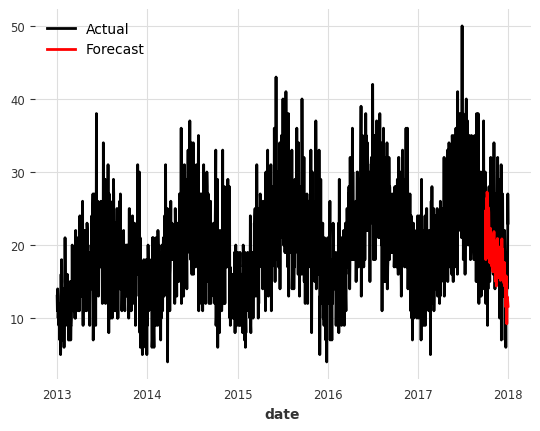

In [93]:
forecast = scaler.inverse_transform(model.predict(len(val)))
series.plot(label='Actual');
forecast.plot(label='Forecast', color='red');
plt.legend()
plt.show()

In [94]:
print("XGBoost MAPE:", mape(val, forecast))

XGBoost MAPE: 27.280016313949062


11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

14. Натренуйте модель Prophet та зробіть висновок про її якість.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.